## Solution to the F20 final

In [14]:
import numpy as np, scipy as sp, pandas as pd, pymc3 as pm, matplotlib.pyplot as plt, arviz as az
from scipy import stats

### Problem 1

In [2]:
scores = pd.read_csv('spread7.csv', index_col = 0)
scores.head()

,home,favorite,underdog,spread,favorite_name,underdog_name,week,diff
21,0,17,23,7.0,LAN,NO,2,-6
24,1,28,23,7.0,SD,DET,2,5
35,1,35,23,7.0,LAN,GB,3,12
37,1,20,10,7.0,LAA,SEA,3,10
56,1,23,17,7.0,BUF,IND,5,6


First, we compute the following probabilities assuming that the quantity $y = (\mbox{outcome} - \mbox{point spread})$ has a distribution $N(0, 14^2)$:

$$
\begin{align*}
&P(\mbox{favorite wins $|$ spread = 7}) \\
&P(\mbox{favorite wins by at least 7 $|$ spread = 7} ) \\
&P(\mbox{favorite wins by at least 7 $|$ spread = 7 and favorite wins} ) \\
\end{align*}
$$

The favorite wins if $y > -7$, so we have
$$
\begin{align*}
&P(\mbox{favorite wins $|$ spread = 7}) = \frac{1}{\sqrt{2\pi 14^2}} \int_{-7}^\infty \exp\left(-\frac{1}{2}\frac{(y - 7)^2}{14^2}\right) dy \approx 0.6915
\end{align*}
$$
where we compute the approximation with:

In [3]:
1-sp.stats.norm(0, 14).cdf(-7)

0.6914624612740131

The favorite wins by at least 7 if $y \geq 0$, which has probability 0.5.

Finally, we can use the definition of conditional probability to find the last probability:

$$ P(\mbox{favorite wins by at least 7 $|$ spread = 7 and favorite wins} ) = \frac{P(\mbox{favorite wins by at least 7 $|$ spread = 7} )}{P(\mbox{favorite wins $|$ spread = 7})} \approx 0.7231 $$

For a comparison, we compute the empirical probabilities from the data set:

In [4]:
print('P(fav wins):', sum(scores['diff'] > 0) / len(scores))
print('P(fav wins by 7):', sum(scores['diff'] >= 7) / len(scores))
print('P(fav wins by 7 | fav wins):', sum(scores['diff'] >= 7) / sum(scores['diff'] > 0))

P(fav wins): 0.7737226277372263
P(fav wins by 7): 0.5474452554744526
P(fav wins by 7 | fav wins): 0.7075471698113207


The first probability is not approximated very well, although the others are better. This may be attributable to the fact that a game ending in a tie score continues for an "overtime" period, reducing the probability that the final score is exactly 0 and transferring that probability mass to neighboring scores (this might be thought of as a "zero-deflated" process), meaning that the continuous approximation fares especially poorly near $y = 0$.

### Problem 2

We'll show two approaches: First, computing the predictive probability explicitly by integrating over the posterior distribution; second, estimating it by sampling from the posterior predictive distribution. Skip to **alternative approach** below if you don't want to deal with integrals :)

First, we consider the hypothesis that the intermediate data showed 8 cases in the vaccine arm and 86 in the placebo arm. Under this hypothesis, and the model
$$
\begin{align*}
y &\sim \mathrm{Binomial}(n, \theta) \\
\theta &\sim \mathrm{Beta}(0.7, 1.0) \\
\end{align*}
$$
the posterior distribution is $\theta | y_{\mathrm{obs}} \sim \mathrm{Beta}(0.7 + 8, 1 + 86)$.

If this is the case, then the remaining data consists of 82 cases in the placebo arm and 0 in the vaccine arm; denote this as $y' = 0$.
To compute the posterior predictive probability of this, we marginalize over $\theta$:

$$ 
\begin{align*}
p(y' = 0 | y_{\mathrm{obs}}) &= \int_0^1 p(y' = 0 | \theta) p(\theta | y_{\mathrm{obs}}) d\theta  \\
&= \frac{1}{B(8.7, 87)}\int_0^1 (1 - \theta)^{82} \theta^{7.7} (1 - \theta)^{86} d\theta \\
&= \frac{1}{B(8.7, 87)}\int_0^1 \theta^{7.7} (1 - \theta)^{168} d\theta
\end{align*}
$$

where $B(8.7, 87)$ is the normalizing constant for a $\mathrm{Beta(8.7, 87)}$ distribution.

We can compute this either using numerical integration, or with repeated integration by parts. Starting with the normalizing constant,
$$
B(8.7, 87) = \int_0^1 \theta^{7.7} (1-\theta)^{86} d\theta
$$
Integrating by parts once,
$$
\int_0^1 \theta^{7.7} (1-\theta)^{86} d\theta = \frac{86}{8.7} \int_0^1 \theta^{8.7} (1-\theta)^{85} d\theta
$$
Repeating until the power on $(1 - \theta)$ is zero,
$$
\int_0^1 \theta^{7.7} (1-\theta)^{86} d\theta = \frac{86!}{(8.7)(9.7)\ldots(93.7)} \int_0^1 \theta^{93.7}d\theta = \frac{86!}{(8.7)(9.7)\ldots(94.7)}
$$

So,
$$
B(8.7, 87) =  \frac{86!}{(8.7)(9.7)\ldots(94.7)}
$$
and,
$$
p(y' = 0 | y_{\mathrm{obs}}) = \frac{(8.7)(9.7)\ldots(94.7)}{86!} \int_0^1 \theta^{7.7} (1 - \theta)^{168} d\theta
$$
The integral has the same form as the beta integral, so we can just apply the same technique:
$$
p(y' = 0 | y_{\mathrm{obs}}) = \frac{(8.7)(9.7)\ldots(94.7)}{86!} \frac{168!}{(8.7)(9.7)\ldots(176.7)} \approx 0.0037
$$
Below we compute using the exact formula and by numerical integration, confirming that they produce approximately the same result.

In [5]:
b = 1
for i in range(86):
    b *= (86 - i) / (8.7 + i)
b /= 94.7
print(b)
sp.special.beta(8.7, 87) # make sure we didn't mess up :)

1.9631007157014142e-13


1.9631007157013905e-13

In [6]:
p = 1
for i in range(168):
    p *= (168 - i) / (8.7 + i)
p /= 176.7
p / b

0.003704002854739326

In [7]:
from scipy import integrate
f = lambda t: (t ** 7.7) * (1 - t) ** 168
sp.integrate.quad(f, 0, 1)[0] / sp.special.beta(8.7, 87)

0.0037042653645103425

By the same approach, under the second hypothesis, the posterior distribution is $\theta | y_{\mathrm{obs}} \sim \mathrm{Beta}(0.7 + 3, 1 + 91)$, and the remaining data consist of 5 cases in the vaccine arm and 77 in the placebo arm.

Then, 
$$ 
\begin{align*}
p(y' = 5 | y_{\mathrm{obs}}) &= \int_0^1 p(y' = 0 | \theta) p(\theta | y_{\mathrm{obs}}) d\theta  \\
&= \frac{1}{B(3.7, 92)}\left(\begin{array}{c}82\\5\end{array}\right)\int_0^1 \theta^5 (1 - \theta)^{77} \theta^{2.7} (1 - \theta)^{91} d\theta \\
&= \frac{1}{B(3.7, 92)}\left(\begin{array}{c}82\\5\end{array}\right)\int_0^1 \theta^{7.7} (1 - \theta)^{168} d\theta
\end{align*}
$$

Integrating by parts again,
$$
p(y' = 5 | y_{\mathrm{obs}}) = \left(\begin{array}{c}82\\5\end{array}\right) \frac{(3.7)(4.7) \ldots (94.7)}{91!} \frac{168!}{(8.7)(9.7)\ldots(176.7)} \approx 0.0926
$$

In [8]:
# Exact formula
b = 1
for i in range(91):
    b *= (91 - i) / (3.7 + i)
b /= 94.7
p = 1
for i in range(168):
    p *= (168 - i) / (8.7 + i)
p /= 176.7
(p / b) * sp.special.binom(82, 5)

0.09261146436606198

In [9]:
# Numerical integration
g = lambda t: sp.special.binom(82,5) * (t ** 7.7) * (1 - t) ** 168
sp.integrate.quad(g, 0, 1)[0] / sp.special.beta(3.7, 92)

0.09261146436820741

This suggests that of these two hypotheses, the second is more plausible: the first yields a predictive probability of 0.0037 for the new data; the second, 0.0926.

**Alternative approach:** We could approximate these results by sampling -- generating values of $\theta$ from the posterior and then sampling the corresponding binomial distribution.

In [10]:
posterior_1 = sp.stats.beta(8.7, 87)
posterior_2 = sp.stats.beta(3.7, 92)

post_smp_1 = posterior_1.rvs(5000)
post_smp_2 = posterior_2.rvs(5000)

post_pred_1 = [sp.stats.binom(82, p).rvs() for p in post_smp_1]
post_pred_2 = [sp.stats.binom(82, p).rvs() for p in post_smp_2]
print(post_pred_1.count(0) / 5000)        # How many times do we see 0 vaccine cases?
print(post_pred_2.count(5) / 5000)        # How many times do we see 5 vaccine cases?

0.0042
0.0872


### Problem 3

In [11]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

grants = pd.read_csv('NWOGrants.csv', sep = ';')
#grants['gender_m'] = (grants.gender == 'm').astype(np.int64)
#grants['gender_f'] = (grants.gender == 'f').astype(np.int64)
grants['genderid'] = LabelEncoder().fit_transform(grants.gender)
grants['discid'] = OrdinalEncoder().fit_transform(grants[['discipline']]).astype(np.int64)
grants

,discipline,gender,applications,awards,genderid,discid
0,Chemical sciences,m,83,22,1,0
1,Chemical sciences,f,39,10,0,0
2,Physical sciences,m,135,26,1,5
3,Physical sciences,f,39,9,0,5
4,Physics,m,67,18,1,6
5,Physics,f,9,2,0,6
6,Humanities,m,230,33,1,2
7,Humanities,f,166,32,0,2
8,Technical sciences,m,189,30,1,8
9,Technical sciences,f,62,13,0,8


We start with a simple model that only includes gender. Below is a forest plot for the intercept (interpreted as a baseline funding probability), and the slope (interpreted as the total effect of gender).

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bm, a]


Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 11 seconds.


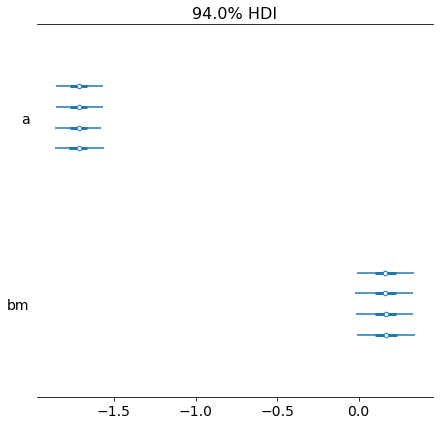

In [16]:
with pm.Model() as univariate_model:
    a = pm.Normal('a', 0, 4)
    bm = pm.Normal('bm', 0, 0.2)
    #bf = pm.Normal('bf', 0, 0.2)
    p = pm.math.invlogit(a + bm * grants.genderid )# + bf * grants.gender_f)
    y = pm.Binomial('y', p=p, n=grants.applications, observed = grants.awards)
    
    trace_univariate = pm.sample(6000, target_accept = 0.9, tune = 3000, chains = 4, cores = 4)
    summary_univariate = az.summary(trace_univariate, var_names = ['a', 'bm'])
    az.plot_forest(trace_univariate, var_names = ['a', 'bm'])
    #pm.traceplot(trace_univariate) # Commenting out because this spits a ton of matplotlib warnings on my current environment

Now, the model including discipline, in the form of 9 varying intercepts.

In [ ]:
with pm.Model() as bivariate_model:
    a = pm.Normal('a', 0, 4)
    bd = pm.Normal('bd', 0, 0.5, shape = 9)
    
    bm = pm.Normal('bm', 0, 0.5)
    p = pm.math.invlogit(a + bd[grants.discid.values] + bm * grants.genderid)
    y = pm.Binomial('y', p=p, n=grants.applications, observed = grants.awards)
    
    trace_bivariate = pm.sample(6000, target_accept = 0.9, tune = 3000, chains = 4, cores = 4)
    summary_bivariate = pm.summary(trace_bivariate, var_names = ['a', 'bm', 'bd'])
    pm.forestplot(trace_bivariate, var_names = ['a', 'bd', 'bm'])
    #pm.traceplot(trace_bivariate)

We see some variation accounted for by discipline, including a few disciplines that are funded at especially high (e.g. physics) or low (e.g. social sciences) rates. (Sorry, social scientists!) Finally, let's compare the posterior distributions of the slopes for each model.

In [ ]:
pm.plot_posterior(trace_univariate, var_names = ['bm'])
pm.plot_posterior(trace_bivariate, var_names = ['bm'])

From the above, we see that in both cases, most of the posterior probability mass lies above 0, suggesting that grants from male applicants are funded at a higher rate. A small amount of this difference is accounted for by discipline, as the model conditioning for discipline has a slightly lower posterior mean and a little more posterior probability mass below 0.

If we add an unobserved variable that influences discipline and funding, this analysis no longer works, because discipline is a collider between gender and our unobserved variable, so conditioning on gender opens a backdoor path.

### Problem 4

In [54]:
frogs = pd.read_csv('reedfrogs.csv', sep=',')
frogs

,Unnamed: 0,density,pred,size,surv,propsurv,pred_id,size_id
0,0,10,no,big,9,0.900000,0,1
1,1,10,no,big,10,1.000000,0,1
2,2,10,no,big,7,0.700000,0,1
3,3,10,no,big,10,1.000000,0,1
4,4,10,no,small,9,0.900000,0,0
5,5,10,no,small,9,0.900000,0,0
6,6,10,no,small,10,1.000000,0,0
7,7,10,no,small,9,0.900000,0,0
8,8,10,pred,big,4,0.400000,1,1
9,9,10,pred,big,9,0.900000,1,1


Three models:
1. 48 independent tanks
2. Hierarchical varying intercepts
3. Hierarchical varying intercepts, plus predation

In [20]:
with pm.Model() as simple_model:
    a = pm.Normal('a', 0, 1, shape = 48)
    p = pm.math.invlogit(a)
    y = pm.Binomial('y', n = frogs.density, p = p, observed = frogs.surv)
    
    trace_simple = pm.sample(4000, tune = 2000, target_accept = 0.9, chains = 4, cores = 4)
    summary_simple = az.summary(trace_simple)
    #pm.traceplot(trace_simple)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 9 seconds.


In [ ]:
with pm.Model() as vi_model:
    μ = pm.Normal('μ', 0, 2)
    η = pm.Normal('η', 0, 1, shape = 48)
    σ = pm.HalfCauchy('σ', 5)
    
    a = pm.Deterministic('a', μ + η * σ)
    p = pm.math.invlogit(a)
    y = pm.Binomial('y', n = frogs.density, p = p, observed = frogs.surv)
    
    trace_vi = pm.sample(4000, tune = 2000, target_accept = 0.9, chains = 4, cores = 4)
    summary_vi = az.summary(trace_vi, var_names = ['μ', 'σ', 'a'])
    #pm.traceplot(trace_simple)

In [ ]:
with pm.Model() as vi_with_pred:
    μ = pm.Normal('μ', 0, 2)
    η = pm.Normal('η', 0, 1, shape = 48)
    σ = pm.HalfCauchy('σ', 5)
    
    b = pm.Normal('b', 0, 2)
    
    a = pm.Deterministic('a', μ + η * σ)
    p = pm.math.invlogit(a + b * frogs.pred_id)
    y = pm.Binomial('y', n = frogs.density, p = p, observed = frogs.surv)
    
    trace_vip = pm.sample(4000, tune = 2000, target_accept = 0.9, chains = 4, cores = 4)
    summary_vip = .summary(trace_vip, var_names = ['μ', 'σ', 'b', 'a'])
    #pm.traceplot(trace_simple)

In [ ]:
pm.compare({'simple':trace_simple, 'vi':trace_vi, 'vi_with_pred':trace_vip})

In [ ]:
summary_vip.iloc[0:3, :]

In [ ]:
summary_vi.iloc[0:2, :]

The WAIC shows little difference in predictive accuracy among the three models. The reduced value of $\sigma$ in the model including predation is because some of the variation between tanks is due to the fact that some tanks have predators and others don't. If this is accounted for by a coefficient in the model, we don't need as high a variance between tanks.

### Problem 5

First, read the data and compute the proportions.

In [ ]:
naes_data = pd.read_csv('naes_grouped.csv', index_col = 0)
naes_data['prop'] = naes_data['yes'] / naes_data['n']

In [ ]:
# Set up data for the GP fit
age = naes_data['age'].values[:, None]
p = naes_data['prop'].values

We set up a GP model using the `Marginal` class from PyMC3 (we don't need anything fancier) using the `marginal_likelihood` method to construct the model and `find_MAP` to fit it. The Matern_{3/2} prior is chosen pretty arbitrarily here.

In [ ]:
with pm.Model() as gp_model:
    eta_process = pm.HalfCauchy('eta_process', 1)
    l_process = pm.Gamma('l_process', 5, 1)         # somewhat arbitrarily pick a characteristic time scale of 5 years
    cov_process = (eta_process ** 2) * pm.gp.cov.Matern32(1, l_process)
    gp = pm.gp.Marginal(cov_func = cov_process)
    
    eta_noise = pm.HalfNormal('eta_noise', 2)
    sigma_noise = pm.HalfCauchy('sigma_noise', 2)
    cov_noise = (eta_noise ** 2) * pm.gp.cov.WhiteNoise(sigma_noise)
    
    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=age, y=p, noise=cov_noise)

    # this line calls an optimizer to find the MAP
    map_est = pm.find_MAP(include_transformed = True)

In [ ]:
tnew = np.arange(min(age)-3, max(age)+3, 0.1)[:, None]

print("Predicting with gp ...")
mu, var = gp.predict(tnew, point=map_est, diag=True)
#mean_pred = mu*std_pm + mean_pm
#var_pred  = var*std_pm**2

# make dataframe to store fit results
fit = pd.DataFrame({"t": tnew.flatten(),
                    "mu_total": mu, #mean_pred,
                    "sd_total": np.sqrt(var)}
                   )
print("Done")

Below we plot the GP fit with a 2 SD band. We're extending predictions a few years past the bounds of the data.

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Proportion vs. age for the NAES data')
plt.xlabel('Age')
plt.ylabel('Proportion of "yes" answers')
plt.plot(tnew, fit.mu_total, label = 'GP fit')
plt.fill_between(x=tnew.flatten(), y1=fit.mu_total - 2*fit.sd_total, y2 = fit.mu_total + 2*fit.sd_total, color = 'lightblue')
plt.plot(age, p, 'k.', label = 'Observed proportions')
plt.legend()
plt.show()

### Problem 6

Functions below to generate the data and run the filter. Note the same dynamics used in each process.

In [ ]:
def get_initial_velocity():
    v = sp.stats.norm(400, 20).rvs()
    angle = sp.stats.norm(np.pi/2, 0.1).rvs()
    vx = v * np.cos(angle)
    vy = v * np.sin(angle)
    return vx, vy

def generate_data(N, dt):
    # Set up initial state
    x, y = 0., 0.
    vx, vy = get_initial_velocity()
    state = np.array([x, vx, y, vy])
    
    # Set up dynamics matrices
    A = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
    B = np.array([[0,  0, 0, 0], [0, 0, 0, 0], [0, 0, -4.9 * dt ** 2, 0], [0, 0, 0, -9.8 * dt]])

    # Generate states with dynamical system
    state_seq = np.zeros((4, N))
    state_seq[:,0] = state
    for i in range(1, N):
        state_seq[:, i] = A @ state + B @ np.array([0, 0, 1, 1])
        state = state_seq[:, i]
        
    # Generate measurements
    measurements = np.zeros((4, N - 1))
    for i in range(N-1):
        measurements[:, i] = state_seq[:, i] + sp.stats.multivariate_normal(mean=np.array([0, 0, 0, 0]), 
                                                                            cov=np.array([[100, 0, 0, 0], [0, 0.25, 0, 0], [0, 0, 100, 0], [0, 0, 0, 0.25]])).rvs()
    return state_seq, measurements
    
def run_filter(measurements, dt, R):
    # Set up dynamics matrices
    A = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
    B = np.array([[0,  0, 0, 0], [0, 0, 0, 0], [0, 0, -4.9 * dt ** 2, 0], [0, 0, 0, -9.8 * dt]])
    
    # Set up initial guess
    x, y = 0., 0.
    vx, vy = 0, 400
    state = np.array([x, vx, y, vy])
    
    state_seq = np.zeros((4, measurements.shape[1]))
    state_seq[:,0] = state
    
    # Set up covariance matrices. Using something close to 0 for the process noise.
    P = np.eye(4)
    Q = 1e-4 * np.eye(4)
    
    for i in range(1, measurements.shape[1]):
        # Time update
        new_state = A @ state + B @ np.array([0, 0, 1, 1])
        P = P + Q
        
        # Measurement update
        K = P @ np.linalg.inv(P + R)
        new_est = new_state + K @ (measurements[:, i] - new_state)
        P = (np.eye(4) - K) @ P
        state_seq[:, i] = new_est
        state = new_est
        #print(P)
    return state_seq

Now we generate some data. By experimentation, about 700 time steps is usually a good amount to see what's going on.

In [ ]:
states, measurements = generate_data(700, 0.1)
plt.figure(figsize=(16, 16))
plt.plot(states[0, :], states[2, :], '--', label = 'true path')
plt.plot(measurements[0, :], measurements[2, :], 'r.', label = 'measurements')
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend()
plt.show()

A few choices of measurement noise covariance are below.

In [ ]:
R = np.array([[100, 0, 0, 0], [0, 0.25, 0, 0], [0, 0, 100, 0], [0, 0, 0, 0.25]])
#R = 1000 * np.eye(4)
#R = 0.001 * np.eye(4)

In [ ]:
est = run_filter(measurements, 0.1, R)

In [ ]:
plt.figure(figsize=(16, 16))
plt.plot(states[0, :], states[2, :], '--', label = 'true path')
plt.plot(measurements[0, :], measurements[2, :], 'r.', label = 'measurements')
plt.plot(est[0, :], est[2, :], 'k', label = 'estimated path', alpha = 0.7)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend()
plt.show()

As we can see, if we choose the true values for the measurement noise covariance the filter tracks the true trajectory very well. If $R$ is made very small, the estimated path is noisier, as it follows the data more closely. If $R$ is made very large, the estimation is very bad, because we trust initial guesses of the velocity too much. (Large noise variance on the position estimates is less harmful.) Tuning by hand shows $R = 10I$ to be a reasonably effective value if we don't know anything about the measurement covariance *a priori.*